# Hyperparameter tuning of the autoencoder

We will find the best parameters for our dense layer model architecture by trying some values out. For grid search, a gpu would have been necessary.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers

#importing the data
gen = np.loadtxt("qcs_gen10000.txt", delimiter=",")

#splitting data into train and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(gen, test_size=0.2, random_state=42, shuffle=True, stratify=None)

mean_train = np.mean(train, axis=1, dtype=np.float64)
mean_test = np.mean(test, axis=1, dtype=np.float64)
stddev_train = np.std(train, axis=1, dtype=np.float64)
stddev_test = np.std(test, axis=1, dtype=np.float64)

#standard scaling the training data
def standard_scale(X, m, s):
    return (X-m)/s

def rescale(X, m, s):
    return X*s+m

train = np.array([standard_scale(train[i], mean_train[i], stddev_train[i]) for i in range(len(train))])
test_scaled = np.array([standard_scale(test[i], mean_test[i], stddev_test[i]) for i in range(len(test))])

Defining the model:

In [2]:
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ provides an explaination 

def create_model(activation,neurons,dropout_rate):
    inputlayer = layers.Input(shape=train.shape[1])
    e2 = layers.Dense(500, activation=activation)(inputlayer)
    e3 = layers.Dense(250, activation=activation)(e2)
    dropout = layers.Dropout(dropout_rate)(e3)
    e4 = layers.Dense(100)(dropout)

    encoded = layers.Dense(neurons)(e4)

    d1 = layers.Dense(100, activation=activation)(encoded)
    d2 = layers.Dense(250, activation=activation)(d1)
    d3 = layers.Dense(500, activation=activation)(d2)
    outputlayer = layers.Dense(1101, activation=activation)(d3)

    model = keras.models.Model(inputlayer, outputlayer, name="autoencoder_dense_v1")

    model.compile(optimizer=keras.optimizers.Adam(), loss='mse')
    return model

Fitting the model:

Which parameters do affect the model's performance significantly? Those will then after be optimized in grid search

1.) Checking for the batch size impact (by choosing extreme values, while keeping the rest normal)

In [8]:
const_activation = 'tanh'
const_drop = 0
const_neurons = 50

model_var_bs = create_model(const_activation, const_neurons,  const_drop)

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
rl_on_plateau= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.67, patience=2,
                                                 verbose=1, min_lr=1e-7)
def fit_model(model, batch_size, verbose):
    results = model.fit(train, train,
                        epochs=50,
                        batch_size=batch_size,
                        validation_split=0.1,
                        verbose=verbose,
                        callbacks=[earlystopping, rl_on_plateau])
    return results

results32 = fit_model(model_var_bs, 32, 0)
results128 = fit_model(model_var_bs, 128, 0)
results256 = fit_model(model_var_bs, 256, 0)

#Comparing the validation loss
print("Val_loss with batch size 32:", results32.history['val_loss'][-1])
print("Val_loss with batch size 128:", results128.history['val_loss'][-1])
print("Val_loss with batch size 256:", results256.history['val_loss'][-1])


Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0003007630087086.

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0002015112101798877.

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00013501251160050743.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.04583813098725e-05.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 6.060711421014276e-05.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 4.060676725202939e-05.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 2.720653359574499e-05.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.8228377484774683e-05.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.2213012305437588e-05.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 8.182718220268725e-06.

Epoch 00028: ReduceLROnPlate

2.) Checking for the activation function impact (we try out tanh, relu with last activation=linear, and elu)

In [11]:
const_bs = 128
model_tanh = create_model("tanh", const_neurons,  const_drop)
model_elu = create_model("elu", const_neurons, const_drop)

#special model with mixed relu and linear
inputlayer = layers.Input(shape=train.shape[1])
e2 = layers.Dense(500, activation="relu")(inputlayer)
e3 = layers.Dense(250, activation="relu")(e2)
e4 = layers.Dense(100)(e3)
encoded = layers.Dense(50)(e4)
d1 = layers.Dense(100, activation="relu")(encoded)
d2 = layers.Dense(250, activation="relu")(d1)
d3 = layers.Dense(500, activation="relu")(d2)
outputlayer = layers.Dense(1101, activation="linear")(d3)
model_relu = keras.models.Model(inputlayer, outputlayer, name="autoencoder_dense_v1")
model_relu.compile(optimizer=keras.optimizers.Adam(), loss='mse')


results_tanh = fit_model(model_tanh, const_bs, 0)
results_elu = fit_model(model_elu, const_bs, 0)
results_relu = fit_model(model_relu, const_bs, 0)

#Comparing the validation loss
print("Val_loss with tanh:", results_tanh.history['val_loss'][-1])
print("Val_loss with elu:", results_elu.history['val_loss'][-1])
print("Val_loss with relu and linear:", results_relu.history['val_loss'][-1])


Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0003007630087086.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0002015112101798877.

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00013501251160050743.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.04583813098725e-05.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 6.060711421014276e-05.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 4.060676725202939e-05.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 2.720653359574499e-05.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.8228377484774683e-05.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.2213012305437588e-05.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 8.182718220268725e-06.
Epoch 00027: early stopping



We see hat elu performs best (similar to relu with linear). Therefore we take elu for the next parameters. Now we want to see if more or fewer neurons work better


Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0003007630087086.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0002015112101798877.
Epoch 00011: early stopping

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0003007630087086.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0002015112101798877.

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00013501251160050743.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.04583813098725e-05.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 6.060711421014276e-05.
Epoch 00016: early stopping

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0

Text(0.5, 1.0, 'Performance of model for different latent space neurons')

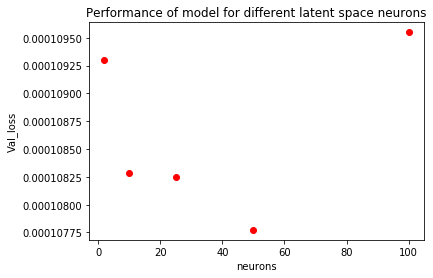

In [21]:
model_neurons_2 = create_model("elu", 2, 0)
model_neurons_10 = create_model("elu", 10, 0)
model_neurons_25 = create_model("elu", 25, 0)
model_neurons_50 = create_model("elu", 50, 0)
model_neurons_100 = create_model("elu", 100, 0)

models_neurons = {model_neurons_2: 2, model_neurons_10: 10, model_neurons_25: 25, 
                  model_neurons_50: 50, model_neurons_100: 100}
results = {}

#training the models
for model_name, n in models_neurons.items():
    result = fit_model(model_name, 128, 0)
    results[model_name] = result

#printing the validation losses for the models
for model_name, n in models_neurons.items():
    print(f"Val_loss with {n} neurons:", results[model_name].history['val_loss'][-1])



#plotting the val_loss for different neurons 
plt.plot(list(models_neurons.values()), [results[model_name].history['val_loss'][-1] for model_name in results.keys()], 'ro')
plt.ylabel("Val_loss")
plt.xlabel("neurons")
plt.title("Performance of model for different latent space neurons")

It seems like the model with 50 neurons performs best. Lastly, we want to see if a dropout layer in the model can improve its performance.


Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0003007630087086.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0002015112101798877.

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00013501251160050743.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.04583813098725e-05.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 6.060711421014276e-05.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 4.060676725202939e-05.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 2.720653359574499e-05.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.8228377484774683e-05.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.2213012305437588e-05.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 8.182718220268725e-06.

Epoch 00028: ReduceLROnPlate

Text(0.5, 1.0, 'Performance of model for different dropout rates')

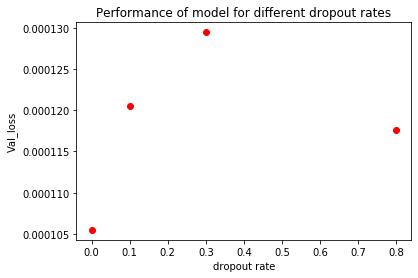

In [23]:
model_dropout_0 = create_model("elu", 50, 0)
model_dropout_10 = create_model("elu", 50, 0.1)
model_dropout_30 = create_model("elu", 50, 0.3)
model_dropout_80 = create_model("elu", 50, 0.8)

models_dropouts = {model_dropout_0: 0, 
                   model_dropout_10: 0.1, 
                   model_dropout_30: 0.3, 
                   model_dropout_80: 0.8}
results = {}

#training the models
for model_name, n in models_dropouts.items():
    result = fit_model(model_name, 128, 0)
    results[model_name] = result

#printing the validation losses for the models
for model_name, n in models_dropouts.items():
    print(f"Val_loss with {n*100}% dropout rate:", results[model_name].history['val_loss'][-1])



#plotting the val_loss for different neurons 
plt.plot(list(models_dropouts.values()), [results[model_name].history['val_loss'][-1] for model_name in results.keys()], 'ro')
plt.ylabel("Val_loss")
plt.xlabel("dropout rate")
plt.title("Performance of model for different dropout rates")

Apparently dropout doesn't help the model. It seems like it doesn't have much influence, because the order of magnitude of the validation losses is the same for every model. 

Grid search was tried but unfortunately didn't work due to the non sufficient working memory in the computer:

In [6]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV



batch_size = [128, 256]
#learn_rates = [1e-7, 1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1]
activations = ['relu', 'tanh']
grid_neurons = [2, 10, 25, 50]
      
param_grid = {'activation':activations,
             'neurons': grid_neurons,
             'batch_size': batch_size}
    
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
#https://www.adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html#scikeras.wrappers.KerasClassifier
model = KerasRegressor(build_fn=create_model, epochs=50,  verbose=0)

In [7]:
model_gridsearch = GridSearchCV(estimator=model, param_grid=param_grid, scoring=None, n_jobs=-1, 
                                refit=True, cv=None, pre_dispatch = '1*n_jobs',verbose=2,
                                return_train_score=True)

In [8]:
results = model_gridsearch.fit(train,train,epochs=50,validation_split=0.1, verbose=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 12.6min finished
C:\ProgramData\Anaconda3\lib\site-packages\joblib\disk.py:122: UserWarning: Unable to delete folder C:\Users\CORINN~1.WEG\AppData\Local\Temp\joblib_memmapping_folder_12612_6894980160 after 5 tentatives.
  .format(folder_path, RM_SUBDIRS_N_RETRY))


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\CORINN~1.WEG\\AppData\\Local\\Temp\\joblib_memmapping_folder_12612_6894980160\\12612-1751341378920-8ee34330cf3b47b183764aceafcbc26c.pkl'